<a href="https://colab.research.google.com/github/Santosh12345841/Analysis/blob/master/INDIA_CORONA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installs
!pip install pycountry_convert 
!pip install folium
!pip install calmap
# !pip install pandas==0.25.1
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_deaths_v4.h5
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_confirmed_v4.h5
!wget https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_usa_c_v2.h5

--2020-06-13 09:07:43--  https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_deaths_v4.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194280 (190K) [application/octet-stream]
Saving to: ‘model_deaths_v4.h5.1’

model_deaths_v4.h5. 100%[===================>] 189.73K  --.-KB/s    in 0.04s   

2020-06-13 09:07:43 (4.20 MB/s) - ‘model_deaths_v4.h5.1’ saved [194280/194280]

--2020-06-13 09:07:46--  https://raw.githubusercontent.com/tarunk04/COVID-19-CaseStudy-and-Predictions/master/models/model_confirmed_v4.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... conn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap

from keras.layers import Input, Dense, Activation, LeakyReLU, Dropout
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [ ]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [ ]:
df_confirmed.head()

Province/State Country/Region      Lat  ...  6/10/20  6/11/20  6/12/20
0            NaN    Afghanistan  33.0000  ...    22142    22890    23546
1            NaN        Albania  41.1533  ...     1341     1385     1416
2            NaN        Algeria  28.0339  ...    10484    10589    10698
3            NaN        Andorra  42.5063  ...      852      852      853
4            NaN         Angola -11.2027  ...      113      118      130

[5 rows x 147 columns]

In [ ]:
df_deaths.head()

Province/State Country/Region      Lat  ...  6/10/20  6/11/20  6/12/20
0            NaN    Afghanistan  33.0000  ...      405      426      446
1            NaN        Albania  41.1533  ...       34       35       36
2            NaN        Algeria  28.0339  ...      732      741      751
3            NaN        Andorra  42.5063  ...       51       51       51
4            NaN         Angola -11.2027  ...        4        5        5

[5 rows x 147 columns]

In [ ]:
df_covid19.head()

Country_Region          Last_Update      Lat  ...  Mortality_Rate  UID  ISO3
0      Australia  2020-06-13 08:33:15 -25.0000  ...        1.396878   36   AUS
1        Austria  2020-06-13 08:33:15  47.5162  ...        3.955696   40   AUT
2         Canada  2020-06-13 08:33:15  60.0010  ...        8.158040  124   CAN
3          China  2020-06-13 08:33:15  30.5928  ...        5.506482  156   CHN
4        Denmark  2020-06-13 08:33:15  56.2639  ...        4.829661  208   DNK

[5 rows x 14 columns]

In [ ]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [ ]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])
# df_recovered.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]] )   

In [ ]:
df_table = df_table[df_table["continent"] != "Others"]

In [ ]:
df_deaths[df_deaths["continent" ]== 'Others']

state             country continent  ...  6/10/20  6/11/20  6/12/20
88    NaN    Diamond Princess    Others  ...       13       13       13
127   NaN            Holy See    Others  ...        0        0        0
236   NaN         Timor-Leste    Others  ...        0        0        0
240   NaN  West Bank and Gaza    Others  ...        3        3        3
246   NaN              Kosovo    Others  ...       31       31       31
247   NaN               Burma    Others  ...        6        6        6
251   NaN          MS Zaandam    Others  ...        2        2        2
260   NaN      Western Sahara    Others  ...        1        1        1

[8 rows x 148 columns]

In [ ]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)

    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19: "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""#+"output/"

In [ ]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

df_countries_cases.fillna(0,inplace=True)
df_continents_cases.fillna(0,inplace=True)

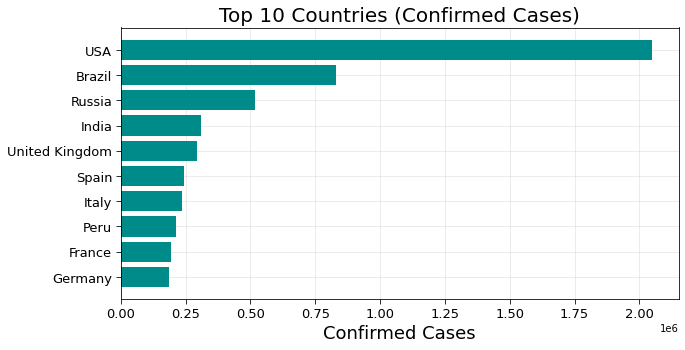

In [ ]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

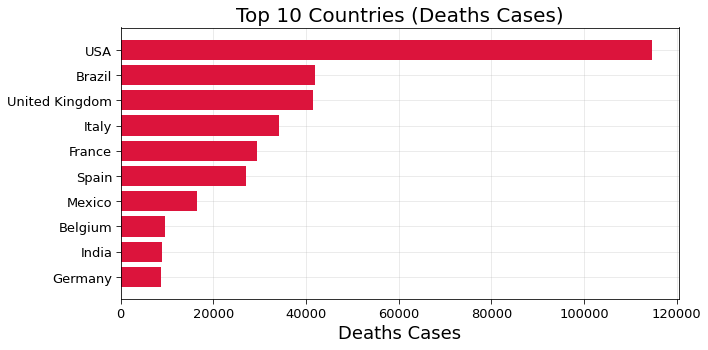

In [ ]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

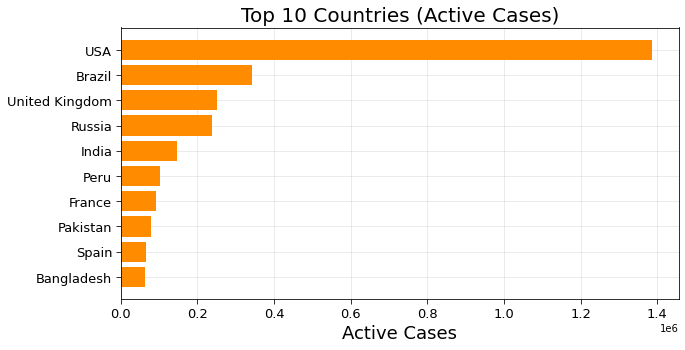

In [ ]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')["Active"].index[-10:],df_countries_cases.sort_values('Active')["Active"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Countries (Active Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Active Cases).png')

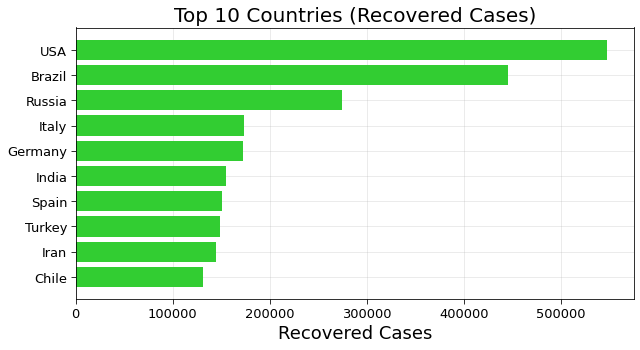

In [ ]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Recovered')["Recovered"].index[-10:],df_countries_cases.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 10 Countries (Recovered Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Recovered Cases).png')

In [ ]:
#Country Wise
df_countries_cases.iloc[:,:].corr().style.background_gradient(cmap='Reds').format("{:.3f}")

In [ ]:
df_data = df_table.groupby(['Last_Update', 'Country_Region'])['Confirmed', 'Deaths'].max().reset_index().fillna(0)
df_data["Last_Update"] = pd.to_datetime( df_data["Last_Update"]).dt.strftime('%m/%d/%Y')

fig = px.scatter_geo(df_data, locations="Country_Region", locationmode='country names', 
                     color=np.power(df_data["Confirmed"],0.3)-2 , size= np.power(df_data["Confirmed"]+1,0.3)-1, hover_name="Country_Region",
                     hover_data=["Confirmed"],
                     range_color= [0, max(np.power(df_data["Confirmed"],0.3))], 
                     projection="natural earth", animation_frame="Last_Update", 
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='COVID-19: Progression of spread'
                    )
fig.update_coloraxes(colorscale="hot")
fig.update(layout_coloraxis_showscale=False)
fig.show()

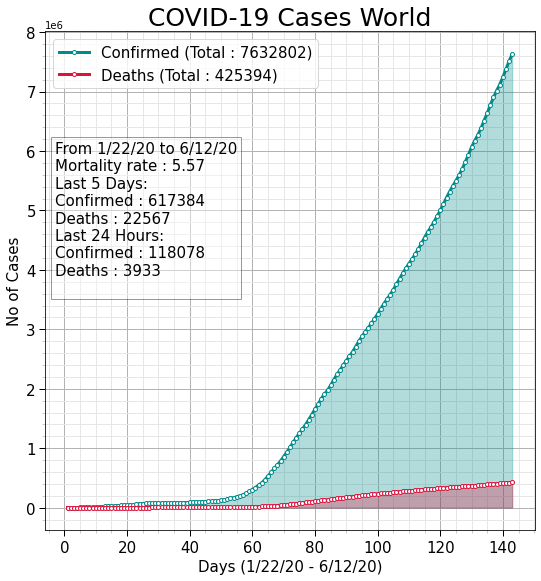

In [ ]:
cols = 1
rows = 1
f = plt.figure(figsize=(10,10*rows))

visualize_covid_cases(df_confirmed, df_deaths,continent = "All",figure = [f,rows,cols, 1])

plt.savefig(out+'COIVD-19-World.png')
plt.show()

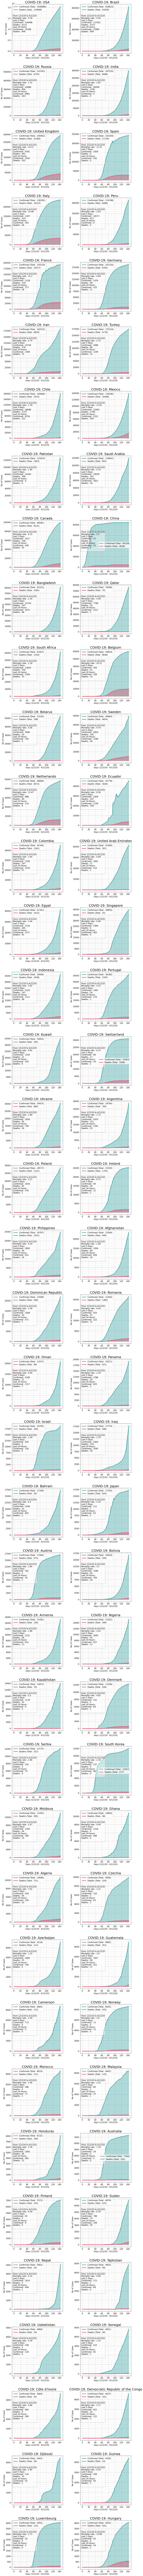

In [ ]:
#COVID-19 Spread Trends in Few Most Affected Countries
df_countries = df_confirmed.groupby(["country"]).sum()
df_countries = df_countries.sort_values(df_countries.columns[-1],ascending = False)
countries = df_countries[df_countries[df_countries.columns[-1]] >= 4000].index

cols =2
rows = int(np.ceil(countries.shape[0]/cols))
f = plt.figure(figsize=(18,7*rows))
for i,country in enumerate(countries):
    visualize_covid_cases(df_confirmed, df_deaths,country = country,figure = [f,rows,cols, i+1])

plt.show()

In [ ]:
df_confirmed[df_confirmed['country']=='India']

state country continent   Lat  ...  6/9/20  6/10/20  6/11/20  6/12/20
131   NaN   India      Asia  21.0  ...  276146   286605   297535   297535

[1 rows x 148 columns]

In [ ]:
df_deaths[df_deaths['country']=='India']

state country continent   Lat  ...  6/9/20  6/10/20  6/11/20  6/12/20
131   NaN   India      Asia  21.0  ...    7750     8498     8498     8498

[1 rows x 148 columns]

In [ ]:
cols = df_confirmed.keys()

In [ ]:
confirmed = df_confirmed.loc[:, cols[5]:cols[-1]]
deaths = df_deaths.loc[:, cols[5]:cols[-1]]
confirmed

1/22/20  1/23/20  1/24/20  1/25/20  ...  6/9/20  6/10/20  6/11/20  6/12/20
0          0        0        0        0  ...   21459    22142    22890    23546
1          0        0        0        0  ...    1299     1341     1385     1416
2          0        0        0        0  ...   10382    10484    10589    10698
3          0        0        0        0  ...     852      852      852      853
4          0        0        0        0  ...      96      113      118      130
..       ...      ...      ...      ...  ...     ...      ...      ...      ...
261        0        0        0        0  ...     514      611      632      639
262        0        0        0        0  ...     524      560      591      632
263        0        0        0        0  ...     141      162      162      163
264        0        0        0        0  ...    4690     4763     4834     4902
265        0        0        0        0  ...       4        4        4        4

[266 rows x 143 columns]

In [ ]:
deaths

1/22/20  1/23/20  1/24/20  1/25/20  ...  6/9/20  6/10/20  6/11/20  6/12/20
0          0        0        0        0  ...     384      405      426      446
1          0        0        0        0  ...      34       34       35       36
2          0        0        0        0  ...     724      732      741      751
3          0        0        0        0  ...      51       51       51       51
4          0        0        0        0  ...       4        4        5        5
..       ...      ...      ...      ...  ...     ...      ...      ...      ...
261        0        0        0        0  ...      12       12       12       12
262        0        0        0        0  ...     127      129      136      139
263        0        0        0        0  ...       2        2        2        2
264        0        0        0        0  ...      48       48       49       49
265        0        0        0        0  ...       0        0        0        0

[266 rows x 143 columns]

In [ ]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
india_cases = [] 
india_death = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    
    
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)

    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)

    india_cases.append(df_confirmed[df_confirmed['country']=='India'][i].sum())
    india_death.append(df_deaths[df_deaths['country']=='India'][i].sum())

In [ ]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_increase = daily_increase(world_cases)
india_daily_increase = daily_increase(india_cases)
india_daily_death_increase = daily_increase(india_death)

In [ ]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
india_cases = np.array(india_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
india_death = np.array(india_death).reshape(-1,1)

In [ ]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [ ]:
import datetime

In [ ]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [ ]:
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, india_cases, test_size=0.28, shuffle=False) 

In [ ]:
X_train_death, X_test_death, y_train_death, y_test_death = train_test_split(days_since_1_22, india_death, test_size=0.28, shuffle=False) 

In [ ]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [ ]:
xgb_confirmed = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'silent': [1],
              'learning_rate': [0.025],
              'n_estimators': [4500],
              'max_depth': [9],
              'min_child_weight': [5],
              'gamma':[0.01],
              'subsample': [0.865],
              'scale_pos_weight':[1],
              'colsample_bytree':[0.875],
              'reg_alpha':[0.00125],
              'reg_lambda':[0.825]}
rscvj1 = RandomizedSearchCV(xgb_confirmed,
                            parameters,
                            n_jobs=5,
                            cv=2)

rscvj1.fit(
    X_train_confirmed, 
    y_train_confirmed)

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   param_distributions={'colsample_bytree': [0.875],
                                        'gamma': [0.01],
                                        'learning_rate': [0.02

In [ ]:
best1_jun1 = rscvj1.best_estimator_
best1_jun1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.875, gamma=0.01,
             importance_type='gain', learning_rate=0.025, max_delta_step=0,
             max_depth=9, min_child_weight=5, missing=None, n_estimators=4500,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0.00125, reg_lambda=0.825, scale_pos_weight=1, seed=None,
             silent=1, subsample=0.865, verbosity=1)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:

xgbj1_grid = GridSearchCV(xgb_confirmed,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=False)

xgbj1_grid.fit(X_train_confirmed,y_train_confirmed)
print("Best Parameters")
print(xgbj1_grid.best_params_)

Best Parameters
{'colsample_bytree': 0.875, 'gamma': 0.01, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 4500, 'nthread': 4, 'objective': 'reg:linear', 'reg_alpha': 0.00125, 'reg_lambda': 0.825, 'scale_pos_weight': 1, 'silent': 1, 'subsample': 0.865}


In [ ]:
xgb_pred = xgbj1_grid.predict(future_forcast)

MAE: 111665.71255716463
MSE: 18628134469.22174


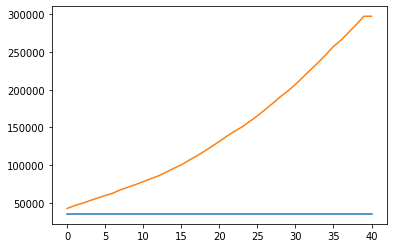

In [ ]:
# check against testing data
xgb_test_pred = xgbj1_grid.predict(X_test_confirmed)
plt.plot(xgb_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(xgb_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(xgb_test_pred, y_test_confirmed))

In [ ]:
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 21500.969390456037
MSE: 563404625.4999082


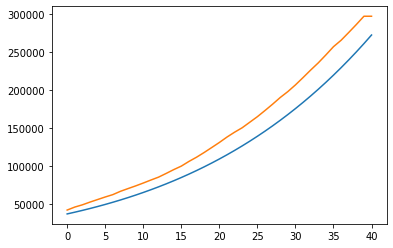

In [ ]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [ ]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=4)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [ ]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 15670.488922060675
MSE: 410751449.0175956


In [ ]:
print(linear_model.coef_)

[[ 4.73683841e+01 -5.18653598e+01  5.73557464e+00 -1.79174586e-01
   1.64876605e-03]]


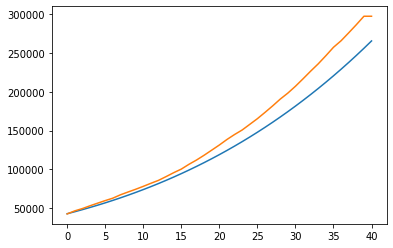

In [ ]:
plt.plot(test_linear_pred)
plt.plot(y_test_confirmed)

In [ ]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                 

In [ ]:
bayesian_search.best_params_

{'alpha_1': 0.0001,
 'alpha_2': 1e-07,
 'lambda_1': 1e-06,
 'lambda_2': 0.0001,
 'tol': 0.01}

In [ ]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 19267.769122235353
MSE: 616369988.6659596


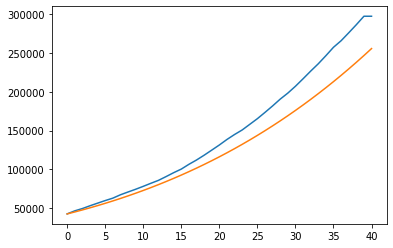

In [ ]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)

In [ ]:
# Future predictions using XGB
xgb_pred = xgb_pred.reshape(1,-1)[0] 
print('XGB future predictions:')
set(zip(future_forcast_dates[-10:], np.round(xgb_pred[-10:])))

XGB future predictions:


{('06/13/2020', 35278.0),
 ('06/14/2020', 35278.0),
 ('06/15/2020', 35278.0),
 ('06/16/2020', 35278.0),
 ('06/17/2020', 35278.0),
 ('06/18/2020', 35278.0),
 ('06/19/2020', 35278.0),
 ('06/20/2020', 35278.0),
 ('06/21/2020', 35278.0),
 ('06/22/2020', 35278.0)}

In [ ]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

SVM future predictions:


{('06/13/2020', 284567.0),
 ('06/14/2020', 296720.0),
 ('06/15/2020', 309302.0),
 ('06/16/2020', 322326.0),
 ('06/17/2020', 335804.0),
 ('06/18/2020', 349748.0),
 ('06/19/2020', 364171.0),
 ('06/20/2020', 379086.0),
 ('06/21/2020', 394507.0),
 ('06/22/2020', 410447.0)}

In [ ]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

Polynomial regression future predictions:


{('06/13/2020', 275424.0),
 ('06/14/2020', 285438.0),
 ('06/15/2020', 295719.0),
 ('06/16/2020', 306272.0),
 ('06/17/2020', 317100.0),
 ('06/18/2020', 328210.0),
 ('06/19/2020', 339606.0),
 ('06/20/2020', 351292.0),
 ('06/21/2020', 363273.0),
 ('06/22/2020', 375555.0)}

In [ ]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('06/13/2020', 265041.0),
 ('06/14/2020', 274515.0),
 ('06/15/2020', 284235.0),
 ('06/16/2020', 294207.0),
 ('06/17/2020', 304434.0),
 ('06/18/2020', 314922.0),
 ('06/19/2020', 325674.0),
 ('06/20/2020', 336694.0),
 ('06/21/2020', 347988.0),
 ('06/22/2020', 359558.0)}

In [ ]:
latest_confirmed = df_confirmed[dates[-1]]
latest_deaths = df_deaths[dates[-1]]

In [ ]:
unique_countries =  list(df_confirmed['country'].unique())

In [ ]:
import operator

In [ ]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[df_confirmed['country']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_confirmed[df_confirmed['country']==unique_countries[i]].sum()

In [ ]:
# number of cases per country/region
print('Confirmed Cases by Country:')
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Confirmed Cases by Country:
USA: 2048986 cases
Brazil: 828810 cases
Russia: 510761 cases
India: 297535 cases
United Kingdom: 294402 cases
Spain: 243209 cases
Italy: 236305 cases
Peru: 214788 cases
France: 193220 cases
Germany: 187226 cases
Iran: 182525 cases
Turkey: 175218 cases
Chile: 160846 cases
Mexico: 139196 cases
Pakistan: 125933 cases
Saudi Arabia: 119942 cases
Canada: 99595 cases
China: 84228 cases
Bangladesh: 81523 cases
Qatar: 76588 cases
South Africa: 61927 cases
Belgium: 59819 cases
Belarus: 52520 cases
Sweden: 49684 cases
Netherlands: 48668 cases
Ecuador: 45778 cases
Colombia: 45344 cases
United Arab Emirates: 41499 cases
Egypt: 41303 cases
Singapore: 39850 cases
Indonesia: 36406 cases
Portugal: 36180 cases
Kuwait: 34952 cases
Switzerland: 31063 cases
Ukraine: 30415 cases
Argentina: 28764 cases
Poland: 28577 cases
Ireland: 25250 cases
Philippines: 24787 cases
Afghanistan: 23546 cases
Dominican Republic: 22008 cases
Romania: 21404 cases
Oman: 21071 cases
Panama: 19211 cases

In [ ]:
import numpy as np

In [ ]:
from math import sqrt

In [ ]:
# looking for best degree for deaths
rmse = 10000
degree = 0
for i in range(101):
    # Transform our cases data for polynomial regression
    poly = PolynomialFeatures(degree=i)
    poly_X_train_death = poly.fit_transform(X_train_death)
    poly_X_test_death = poly.fit_transform(X_test_death)
    poly_future_forcast = poly.fit_transform(future_forcast)

    # polynomial regression cases
    linear_model = LinearRegression(normalize=True, fit_intercept=False)
    linear_model.fit(poly_X_train_death, y_train_death)
    test_linear_pred = linear_model.predict(poly_X_test_death)
    linear_pred = linear_model.predict(poly_future_forcast)

    # evaluating with RMSE
    rm = sqrt(mean_squared_error(y_test_death, test_linear_pred))
    if(rm<rmse):
        rmse = rm
        degree = i
    if(i==100):
        print('the best mae is:',round(rmse,2))
        print('the best degree for cases is:',degree)

the best mae is: 118.39
the best degree for cases is: 4


In [ ]:
# Transform our cases data for polynomial regression
poly = PolynomialFeatures(degree=6)
poly_X_train = poly.fit_transform(X_train_confirmed)
poly_X_test = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

# Transform our death data for polynomial regression
poly_death = PolynomialFeatures(degree=3)
poly_X_train_death = poly_death.fit_transform(X_train_death)
poly_X_test_death = poly_death.fit_transform(X_test_death)
poly_future_forcast_death = poly_death.fit_transform(future_forcast)

In [ ]:
svm_death = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svm_death.fit(X_train_death, y_train_death)
svm_pred_death = svm_death.predict(future_forcast)

MAE: 3159.456310252778
MSE: 12164292.037195977


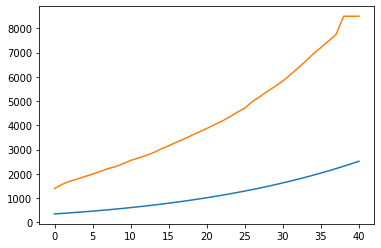

In [ ]:
# check against testing data
svm_test_pred_death = svm_death.predict(X_test_death)
plt.plot(svm_test_pred_death)
plt.plot(y_test_death)
print('MAE:', mean_absolute_error(svm_test_pred_death, y_test_death))
print('MSE:',mean_squared_error(svm_test_pred_death, y_test_death))

In [ ]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred_death[-10:])))

SVM future predictions:


{('06/13/2020', 2626.0),
 ('06/14/2020', 2738.0),
 ('06/15/2020', 2855.0),
 ('06/16/2020', 2975.0),
 ('06/17/2020', 3099.0),
 ('06/18/2020', 3228.0),
 ('06/19/2020', 3361.0),
 ('06/20/2020', 3499.0),
 ('06/21/2020', 3641.0),
 ('06/22/2020', 3788.0)}

In [ ]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=4)
poly_X_train_death = poly.fit_transform(X_train_death)
poly_X_test_death = poly.fit_transform(X_test_death)
poly_future_forcast = poly.fit_transform(future_forcast)

In [ ]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_death, y_train_death)
test_linear_pred = linear_model.predict(poly_X_test_death)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_death))
print('MSE:',mean_squared_error(test_linear_pred, y_test_death))

MAE: 100.68158126619231
MSE: 14017.015620984233


In [ ]:
print(linear_model.coef_)

[[ 1.59628563e+00 -1.73186180e+00  1.91660534e-01 -5.98972878e-03
   5.48032646e-05]]


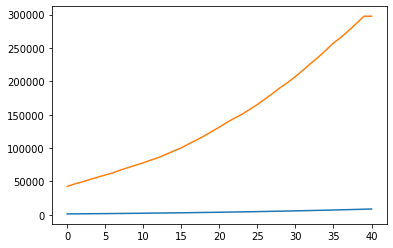

In [ ]:
plt.plot(test_linear_pred)
plt.plot(y_test_confirmed)

In [ ]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

Polynomial regression future predictions:


{('06/13/2020', 9075.0),
 ('06/14/2020', 9406.0),
 ('06/15/2020', 9746.0),
 ('06/16/2020', 10094.0),
 ('06/17/2020', 10452.0),
 ('06/18/2020', 10820.0),
 ('06/19/2020', 11197.0),
 ('06/20/2020', 11583.0),
 ('06/21/2020', 11979.0),
 ('06/22/2020', 12385.0)}

In [ ]:
# bayesian ridge polynomial regression
tol = [1e-5, 1e-4, 1e-3]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-8, 1e-7, 1e-6, 1e-5]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-8, 1e-7, 1e-6, 1e-5]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_death, y_train_death)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-08, 1e-07, 1e-06, 1e-05],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        

In [ ]:
bayesian_search.best_params_

{'alpha_1': 0.0001,
 'alpha_2': 1e-08,
 'lambda_1': 1e-06,
 'lambda_2': 1e-05,
 'tol': 0.001}

In [ ]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_death)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_death))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_death))

MAE: 127.13791842332778
MSE: 28441.745414844743


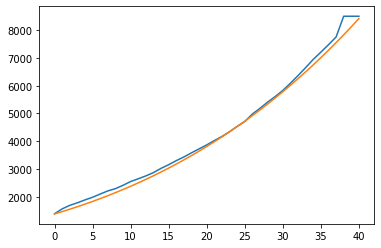

In [ ]:
plt.plot(y_test_death)
plt.plot(test_bayesian_pred)

In [ ]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('06/13/2020', 8720.0),
 ('06/14/2020', 9032.0),
 ('06/15/2020', 9353.0),
 ('06/16/2020', 9682.0),
 ('06/17/2020', 10020.0),
 ('06/18/2020', 10366.0),
 ('06/19/2020', 10721.0),
 ('06/20/2020', 11084.0),
 ('06/21/2020', 11457.0),
 ('06/22/2020', 11839.0)}